# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #4
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Thursday, Febrary 23rd, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Optimization (Continued)

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x  + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Part A: Further problems with descent algorithms
Using your implementation of gradient descent and stochastic gradient descent, document the behaviour of your two algorithms for the following starting points, and for a number of stepsizes of your choice:
- $(\lambda_1, \lambda_2) = (-2.47865, 0)$
- $(\lambda_1, \lambda_2) = (-3, 0)$
- $(\lambda_1, \lambda_2) = (-5, 0)$
- $(\lambda_1, \lambda_2) = (-10, 0)$
Based on your analysis of the lost function $L$, explain what is happening to your descent algorithms.

# IMPORT LIBRARIES AND SET UP THE DATA

In [1]:
import pandas as pd
import time
import numpy as np
import math

import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 14
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
%matplotlib inline

sns.set_style("darkgrid")
plt.style.use('ggplot')

# disable warnings
import warnings
warnings.simplefilter('ignore')

# loss function coefficients
c1,c2,c3 = 0.000045,0.000098,0.003926

# import data, set X and Y values
hw_data = pd.read_csv('./HW3_data-1.csv', header=None)
hw_data = np.array(hw_data).T
X = hw_data[:,0]
Y = hw_data[:,1]

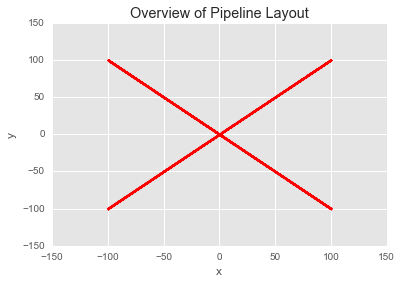

In [2]:
# visualization of the data - what does the pipeline look like?
plt.scatter(X, Y, color='r', s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Overview of Pipeline Layout')
plt.show()

# SETTINGS for GRADIENT and STOCHASTIC GRADIENT DESCENT

In [3]:
# calculate the net loss function - sum over X and Y using the net loss function. 
def f(X, Y, lambda_1, lambda_2):
    fs = c1*(lambda_2**2)*Y - c2*(lambda_2**2)*X + lambda_1*exp_fn(X, Y, lambda_1, lambda_2)
    return np.sum(fs)

def exp_fn(X, Y, lambda_1, lambda_2):
    return c3*X*np.exp((Y**2 - X**2)*(lambda_1**2 + lambda_2**2))

# Calculate net loss function derivate values using Lambda_1 and Lamba_2 as input.
def fprime_lambda_1(X, Y, lambda_1, lambda_2):
    fp = -2*c2*lambda_1*X + (1 + 2*(lambda_1**2)*(Y**2 - X**2))*exp_fn(X, Y, lambda_1, lambda_2)
    return np.sum(fp)

def fprime_lambda_2(X, Y, lambda_1, lambda_2):
    fp = 2*c1*lambda_2*Y + 2*lambda_1*lambda_2*(Y**2 - X**2)*exp_fn(X, Y, lambda_1, lambda_2)
    return np.sum(fp)

# define stopping condition to be used for gradient descent
def stopping_condition_precision(lmd):
    return np.linalg.norm(np.array([lmd[0], lmd[1]]) - np.array([2.05384, 0])) > 1e-3

In [4]:
# GRADIENT DESCENT
def gradient_descent(X, Y, lambdas_init, stopping_condition, step=0.001, maxsteps=0, precision=1e-3):

    # number of data points
    m = Y.size 
    
    # collect the costs
    costs = []
    
    # set the initial lambdas for gradient descent
    lmd = lambdas_init
   
    # to store all parameters
    history = []
    
    # a counter is needed to determine if the max steps allowed has been reached
    counter = 0
    
    old_cost = 0
    
    # calculate the current cost
    current_cost = f(X, Y, *(lmd))
    
    # make updates based on current conditions
    costs.append(current_cost)
    history.append(lmd)
    counter+=1
    update_times = []
    
    while stopping_condition(lmd):
        
        # start the timer for processing this iteration 
        start = time.time()
        
        old_cost = current_cost
        
        # get gradient of average loss function
        gradient = 1000*np.array([fprime_lambda_1(X,Y,*(lmd)), fprime_lambda_2(X,Y,*(lmd))])/m
        
        # take one step in the gradient direction
        lmd = lmd - step * gradient # update
        
        # stop the timer for processing this iteration
        end = time.time()
        
        update_times.append(end-start)
        
        # add the new parameters to the history
        history.append(lmd)
        current_cost = f(X, Y, *(lmd))
        costs.append(current_cost)
        counter+=1
        
        # if we've hit maximum steps allowed, stop!
        if maxsteps:
            if counter == maxsteps:
                break
                
    return history, costs, counter, lmd, update_times

In [5]:
# STOCHASTIC GRADIENT DESCENT
def sgd(X, Y, lambdas_init, stopping_condition, step=0.001, maxsteps=0, cost=False, precision=1e-3):

    # number of data points
    m = Y.size 
    
    # shuffle the data before doing descent
    # use np.random to shuffle the data
    shuffle = np.random.permutation(m)      
    X = X[shuffle]
    Y = Y[shuffle]
            
    # to store all thetas
    history = [] 
    history_costs = []
    update_times = []
    
    old_lambda = 0
    
    # set the initial lambdas for stochastic gradient descent
    lmd = lambdas_init
    counter = 0
    epoch = 0 
    
    # make updates based on current conditions 
    history.append(lmd)
    
    # maintain the index of the current data point
    i = 0 

    # save the costs 
    if cost:
        current_cost = f(X[i],Y[i], *(lmd))
        counter+=1
        cost_sum = current_cost
        history_costs.append(cost_sum/counter)
    
    # run through each data point
    while stopping_condition(lmd):
        
        # start the timer for processing this iteration
        start = time.time()
        
        # update gradient 
        # get gradient of average loss function
        # scale the gradient by 1000 for a faster convergence
        gradient = 1000*np.array([fprime_lambda_1(X[i],Y[i],*(lmd)), fprime_lambda_2(X[i],Y[i],*(lmd))])
        old_lambda = lmd
        
        #take one step in the gradient direction
        lmd = lmd - step * gradient
        
        # stop the timer for processing this iteration
        end = time.time()
        
        update_times.append(end-start)
        
        # increment index for the observation
        i += 1
        
        # iterations have reached past the end of the data 
        if i == m:
            epoch +=1
            
            # shuffle the data for the next pass thru
            shuffle = np.random.permutation(m)
            X = X[shuffle]
            Y = Y[shuffle]
            
            # reset the index
            i = 0
     
        # record the costs 
        if cost:
            current_cost = f(X[i],Y[i], *(lmd))
            cost_sum += current_cost
            
            #add our new parameters to the history
            history_costs.append(cost_sum / counter)
        
        counter +=1
        history.append(lmd)
        
        # if we've hit maximum steps allowed, stop!
        if maxsteps:
            if counter == maxsteps:
                break
                        
    return history, counter, epoch, history_costs, lmd, update_times

# document the behaviour of your two algorithms for the following starting points, and for a number of stepsizes of your choice:



Computing gradient descent starting at (-2.47865, 0)
	with step size 0.001, 	with step size 0.01, 	with step size 0.1, 

Computing stochastic g.d. starting at (-2.47865, 0)
	with step size 0.001, 	with step size 0.01, 	with step size 0.1, 

Computing gradient descent starting at (-3, 0)
	with step size 0.001, 	with step size 0.01, 	with step size 0.1, 

Computing stochastic g.d. starting at (-3, 0)
	with step size 0.001, 	with step size 0.01, 	with step size 0.1, 

Computing gradient descent starting at (-5, 0)
	with step size 0.001, 	with step size 0.01, 	with step size 0.1, 

Computing stochastic g.d. starting at (-5, 0)
	with step size 0.001, 	with step size 0.01, 	with step size 0.1, 

Computing gradient descent starting at (-10, 0)
	with step size 0.001, 	with step size 0.01, 	with step size 0.1, 

Computing stochastic g.d. starting at (-10, 0)
	with step size 0.001, 	with step size 0.01, 	with step size 0.1, 

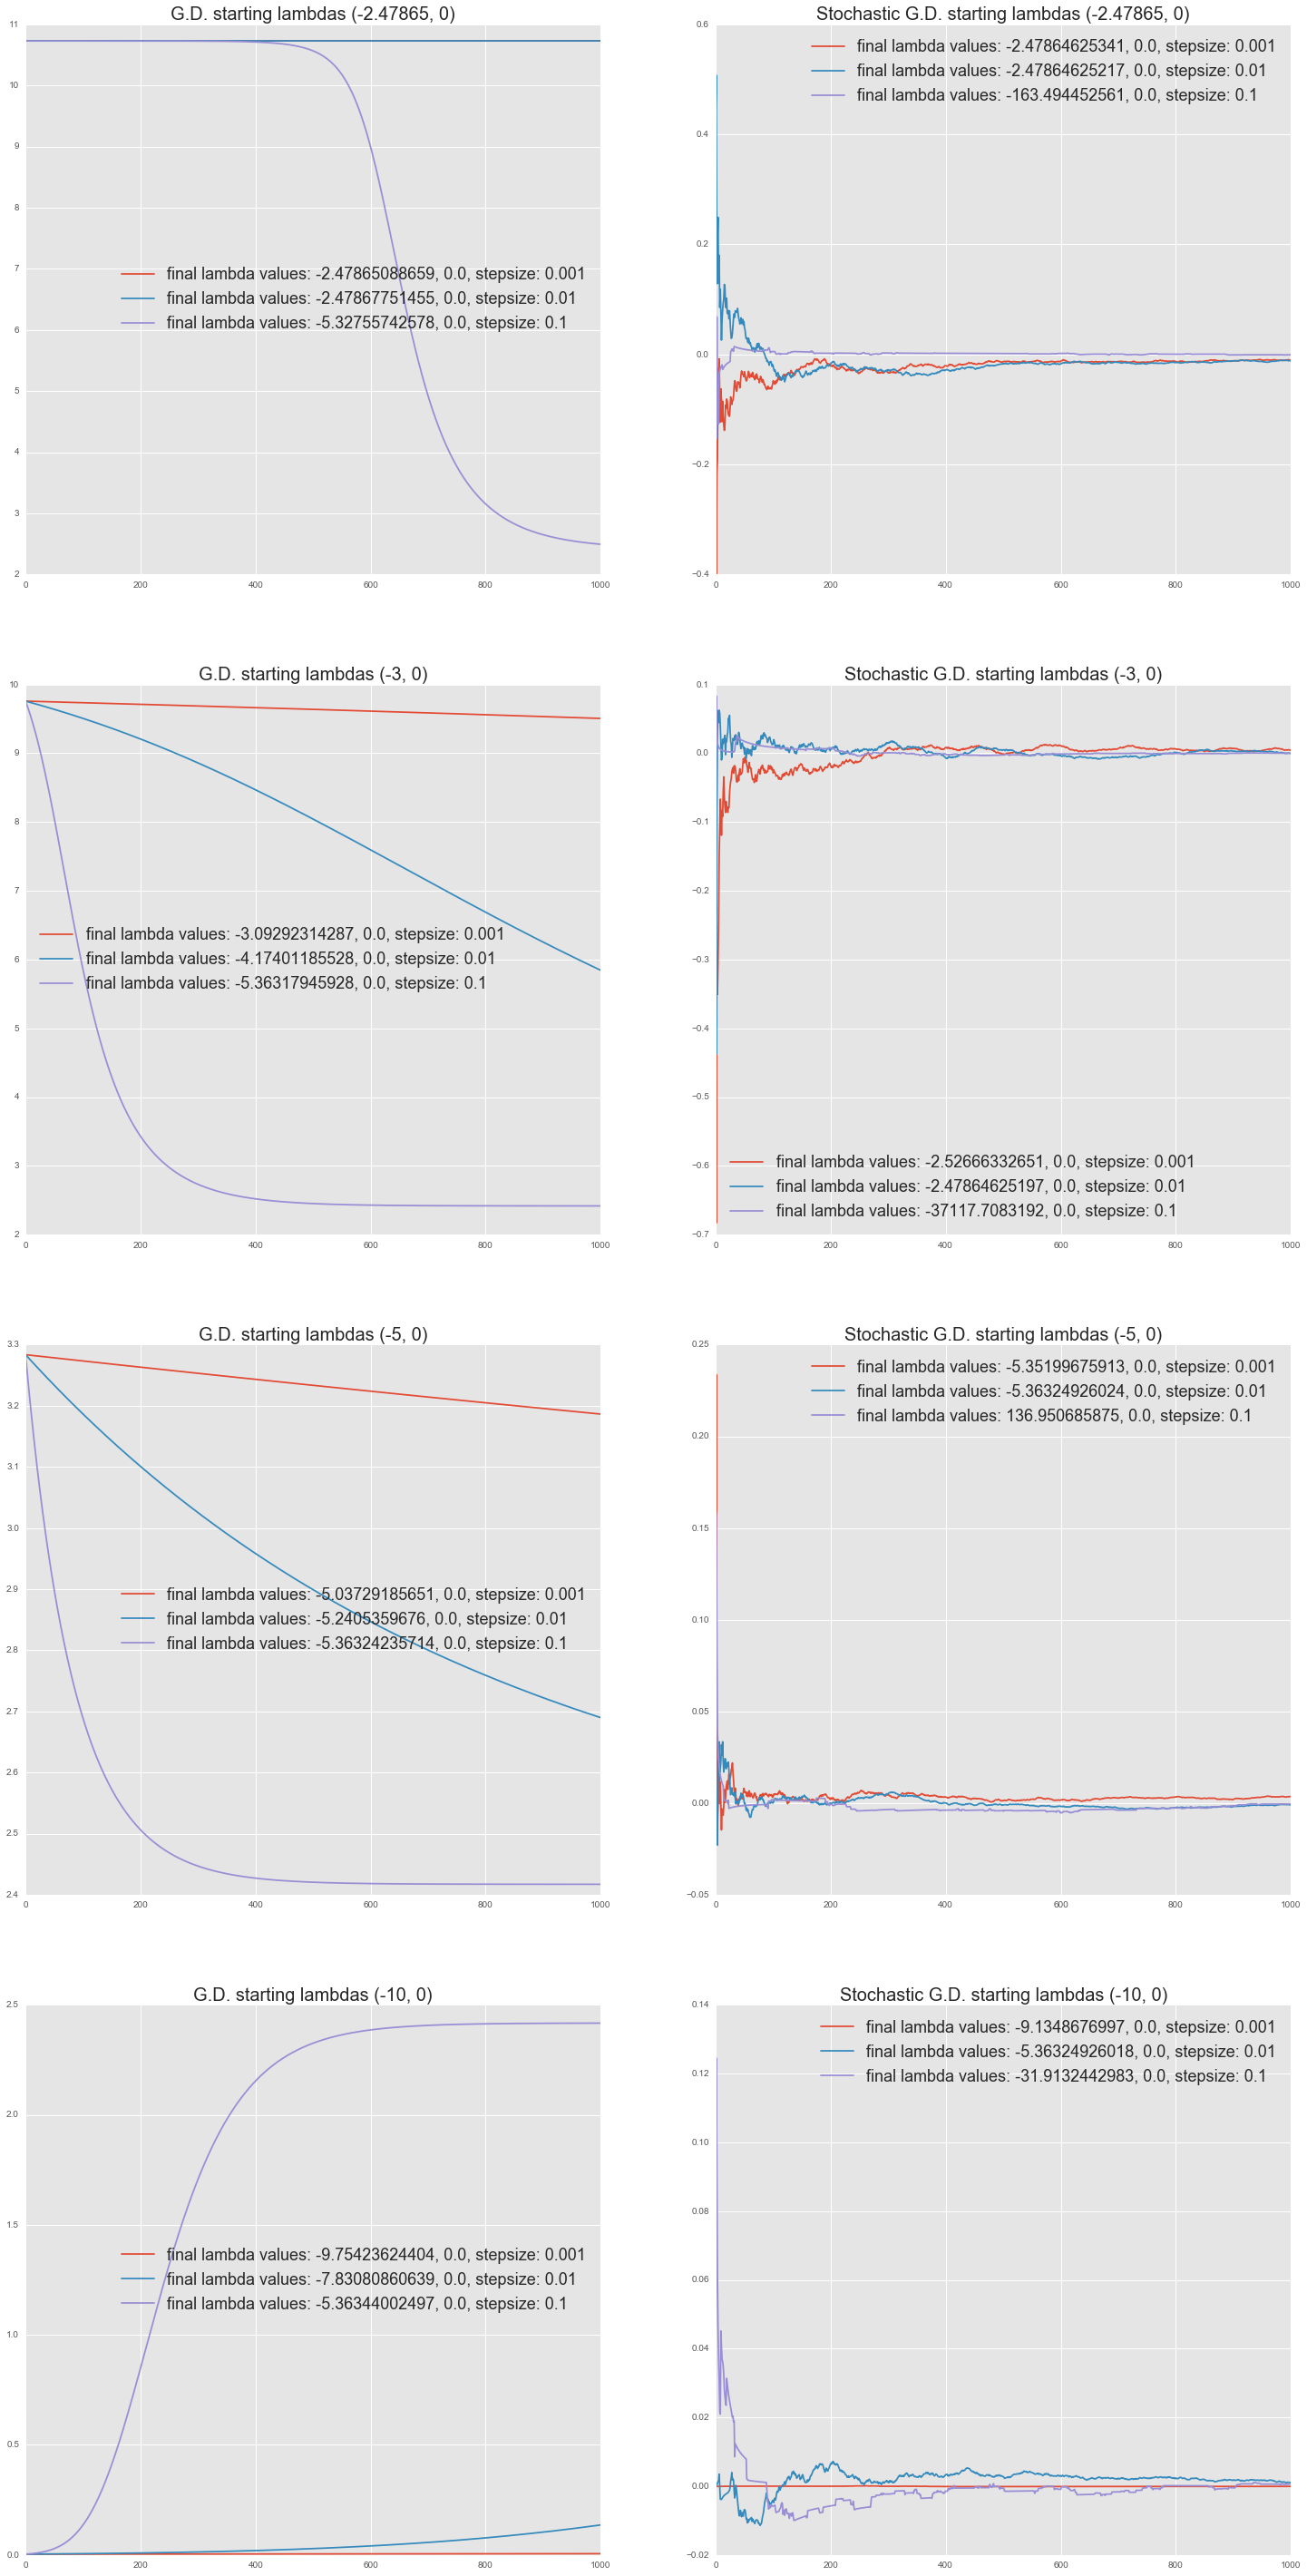

In [6]:
# use three different step sizes
steps = [0.001, 0.01, 0.1]

# set the provided starting points
lambdas = [(-2.47865,0), (-3,0), (-5,0), (-10,0)]

# create a increment for the subplots
i=1

# set the size for each subplot
plt.figure(figsize=(25, 50))

# for each of the starting points
for lmd in lambdas:
    
    # create a subplot for side by side comparisons
    plt.subplot('42' + str(i))
    
    print("\n\nComputing gradient descent starting at", lmd)
    
    # for each of the step sizes
    for step in steps:
        print("\twith step size", str(step)+", ", end="")
        
        # compute gradient descent
        history, costs, counter, lmd_gd, update_times = gradient_descent(X, Y, 
                                                                         lmd, 
                                                                         stopping_condition=stopping_condition_precision, 
                                                                         step=step, 
                                                                         maxsteps=1000)
        
        # plot the results and display the final lambdas and at what step size it occurred
        plt.plot(range(len(costs)), costs, label='final lambda values: '+str(lmd_gd[0]) + ", " + str(lmd_gd[1]) + ', stepsize: ' + str(step))

    plt.title('G.D. starting lambdas ' + str(lmd), fontsize=20)
    plt.legend(loc="best", fontsize=18)
    
    # increment the counter and set the next subplot
    i+=1
    plt.subplot('42' + str(i))
    
    print("\n\nComputing stochastic g.d. starting at", lmd)
    
    # for each of the step sizes
    for step in steps:
        print("\twith step size", str(step)+", ", end="")
        
        # compute stochastic gradient descent
        history_sgd, counter_sgd, epoch_sgd, history_costs_sgd, lambda_sgd, update_times_sgd = sgd(X, Y, 
                                                                                lmd, 
                                                                                stopping_condition=stopping_condition_precision, 
                                                                                step=step, 
                                                                                maxsteps=1000, 
                                                                                cost=True)
        
        # plot the results and display the final lambdas and at what step size it occurred
        plt.plot(range(len(history_costs_sgd)), history_costs_sgd, label='final lambda values: '+str(lambda_sgd[0]) + ", " + str(lambda_sgd[1]) + ', stepsize: ' + str(step))
        
    plt.title('Stochastic G.D. starting lambdas ' + str(lmd), fontsize=20)
    plt.legend(loc="best", fontsize=18)
    
    # increment the counter and set the next subplot
    i+=1

# Compare the global minimum of the loss function with the approximate local optimum of g.d. and s.g.d.

In [7]:
print("The global minimum is ", f(X,Y, 2.05384, 0), "and the local optimum is ", f(X,Y, -5.363, 0))

The global minimum is  -10.776501027 and the local optimum is  2.41773031925


Based on the above data with the three step sizes, 0.001, 0.01, and 0.1, the gradient descent graph becomes stuck at the local optimum, which is around $\lambda1, $\lambda2 (-5.363, 0). 

Stochastic Gradiet Descent yielded different final lambda values with no consistent results. The lack of consistency indicates that further testing for an optimal learning rate  may be needed.

### Part B: Simulated Annealing
Implement Simulated Annealing initalized at $(\lambda_1, \lambda_2) = (-5, 0)$ to minimize our lost function $L$. Compare your results to what you obtained for gradient descent and stochastic gradient descent initialized at $(\lambda_1, \lambda_2) = (-5, 0)$.

For your Simulated Annealing implementation, we suggest *starting* with following settings for parameters (you should further experiment with and tweak these or feel free to set your own):

- Proposal distribution: bivariate normal with covariance $[[1, 0], [0, 1]]$
- Min Length: 500
- Max Temperature: 10

You should also set your own cooling schedule.

**Extra Credit**
For each temperature, plot the parameters accepted or the cost function with respect to the iteration number. What is happening to the these parameters or costs over iterations? Connect the trends you observe in the visualization to the lecture on Markov Chains.

# Set up Simulated Annealing

In [8]:
# define the proposal distribution
mean = (0, 0)
cov = [[1, 0], [0, 1]]
pfxs = lambda l1, l2: np.random.multivariate_normal((l1, l2), [[1, 0], [0, 1]], 1)[0]

# cooling schedule - define the functions
# We reduce the temperature by a multiplicative factor of 0.8, 
# and increase the epoch length by a factor of 1.2
tf = lambda t: 0.8*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

In [9]:
def sa(energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc):
    
    # Accumulate results in the same form as initals
    accumulator=[]
    
    # Our initial state is in initials['solution']
    # initial values of lambda 1 and lambda 2
    best_solution = old_solution = initials['solution']
    
    # Our initial temperature is in initials['T']
    T=initials['T']
    
    # Our initial length (i.e. number of iterations per epoch)
    length=initials['length']
    
    # initialize the energy of our current state by running the 
    # energy function on our initial solution
    best_energy = old_energy = energyfunc(X, Y, *old_solution)
    
    # keep track of accepted proposals and total iterations
    accepted=0
    total=0
    
    # total number of epochs
    for index in range(epochs):
        print("Epoch", index)
        
        # if we're past the first index, we need
        # to update our cooling schedule and iteration
        # schedule 
        if index > 0:
            # decrease the temperature according to a cooling schedule
            T = tempfunc(T)
            # the number of iterations increases as the temperature decreases 
            length=iterfunc(length)
            
        print("Temperature", T, "Length", length)
        
        # run through the iterations for each epoch
        for it in range(length):
            
            # keep track of total proposals
            total+=1
            
            # get a new proposal and calculate its energy
            
            # new values of l1 and l2
            new_solution = proposalfunc(*old_solution)
            
            # new value of the loss func 
            new_energy = energyfunc(X, Y, *new_solution)
            
            # Use a min here as you could get a "probability" > 1
            alpha = min(1, np.exp((old_energy - new_energy)/T))
            
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)):
               
                # Accept proposed solution
                accepted+=1
                accumulator.append((T, new_solution, new_energy))
                
                if new_energy < best_energy:
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index=total
                    best_temp=T
                
                old_energy = new_energy
                old_solution = new_solution
            else:
                # Keep the old stuff
                accumulator.append((T, old_solution, old_energy))
    
    best_meta=dict(index=best_index, temp=best_temp)
    print("frac accepted", accepted/total, "total iterations", total, 'bmeta', best_meta)
    return best_meta, best_solution, best_energy, accumulator

# MIN. LENGTH OF 500 and MAX. TEMP of 10

In [11]:
# run the algorithm initalized at (λ1,λ2)=(−5,0) to minimize our lost function L.
lambdas_init = [-5, 0]
inits=dict(solution=lambdas_init, length=500, T=10)
bmeta, bs, be, out = sa(f, inits, 30, tf, itf, pfxs)

Epoch 0
Temperature 10 Length 500
Epoch 1
Temperature 8.0 Length 600
Epoch 2
Temperature 6.4 Length 720
Epoch 3
Temperature 5.120000000000001 Length 864
Epoch 4
Temperature 4.096000000000001 Length 1037
Epoch 5
Temperature 3.276800000000001 Length 1245
Epoch 6
Temperature 2.621440000000001 Length 1494
Epoch 7
Temperature 2.097152000000001 Length 1793
Epoch 8
Temperature 1.6777216000000008 Length 2152
Epoch 9
Temperature 1.3421772800000007 Length 2583
Epoch 10
Temperature 1.0737418240000005 Length 3100
Epoch 11
Temperature 0.8589934592000005 Length 3720
Epoch 12
Temperature 0.6871947673600004 Length 4464
Epoch 13
Temperature 0.5497558138880003 Length 5357
Epoch 14
Temperature 0.4398046511104003 Length 6429
Epoch 15
Temperature 0.3518437208883203 Length 7715
Epoch 16
Temperature 0.28147497671065624 Length 9258
Epoch 17
Temperature 0.22517998136852502 Length 11110
Epoch 18
Temperature 0.18014398509482002 Length 13332
Epoch 19
Temperature 0.14411518807585602 Length 15999
Epoch 20
Temperatu

In [12]:
# best solution and best energy
bs, be

(array([  2.23282962e+00,  -1.23804029e-05]), -10.850372957862874)

Extra Credit For each temperature, plot the parameters accepted or the cost function with respect to the iteration number. What is happening to the these parameters or costs over iterations? Connect the trends you observe in the visualization to the lecture on Markov Chains.

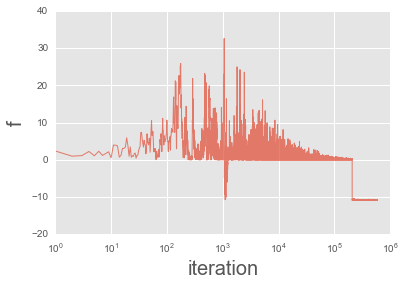

In [13]:
plt.plot(range(len(out)),[e[2] for e in out], alpha=0.7, lw=1);
plt.xscale('log', fontsize=20)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('f', fontsize=20)

This plot displays changes in the cost function as the iterations increase.  Initially, there are large fluctations in cost. Over time, as the number of iterations increase, the cost function stabilizes. The stabilization demonstrates how Markov chain converges to stationary distributions.

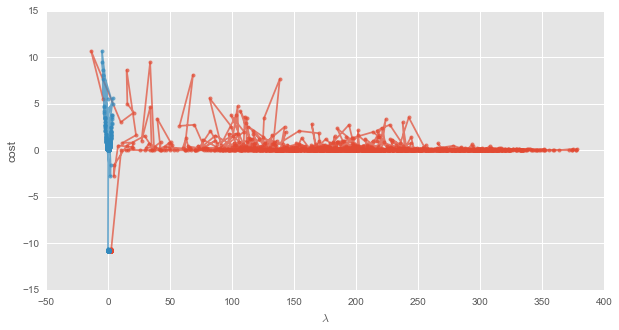

In [14]:
plt.figure(figsize=(10,5))
xs = np.linspace(-10.,10.,1000)
eout=list(enumerate(out))
plt.plot([e[1] for i,e in eout if i%100==0], [e[2] for i,e in eout if i%100==0], 'o-', alpha=0.7, markersize=4)
plt.ylabel('cost')
plt.xlabel('$\lambda$')

This plot displays the lambda outputs during the simulated annealing process.  Like the plot before there is also is also large variability in the lambda vaules.  As the temperature is reduced however, the lambda values converge and eventually settle around the optimum values. 

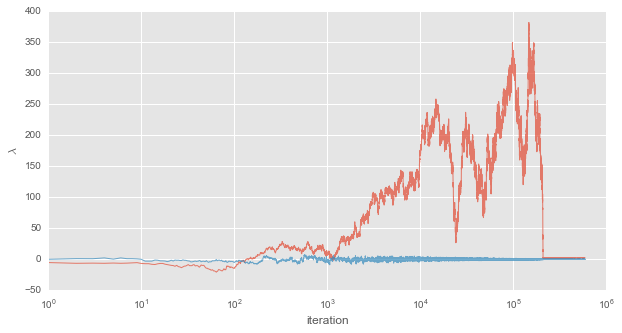

In [15]:
plt.figure(figsize=(10,5))
plt.plot([e[1] for e in out], alpha=0.7, lw=1);
plt.xscale('log')
plt.xlabel('iteration')
plt.ylabel('$\lambda$')

The plot above displays the lambda values as a function of the number of interations.  As the number of iterations increases, there is a convergence over time.

#  further experiment with and tweak the settings

# Use a minimum length of 300 and max temp of 10

In [16]:
lambdas_init = [-5, 0]
inits=dict(solution=lambdas_init, length=300, T=10)
bmeta, bs, be, out = sa(f, inits, 30, tf, itf, pfxs)

Epoch 0
Temperature 10 Length 300
Epoch 1
Temperature 8.0 Length 360
Epoch 2
Temperature 6.4 Length 432
Epoch 3
Temperature 5.120000000000001 Length 519
Epoch 4
Temperature 4.096000000000001 Length 623
Epoch 5
Temperature 3.276800000000001 Length 748
Epoch 6
Temperature 2.621440000000001 Length 898
Epoch 7
Temperature 2.097152000000001 Length 1078
Epoch 8
Temperature 1.6777216000000008 Length 1294
Epoch 9
Temperature 1.3421772800000007 Length 1553
Epoch 10
Temperature 1.0737418240000005 Length 1864
Epoch 11
Temperature 0.8589934592000005 Length 2237
Epoch 12
Temperature 0.6871947673600004 Length 2685
Epoch 13
Temperature 0.5497558138880003 Length 3222
Epoch 14
Temperature 0.4398046511104003 Length 3867
Epoch 15
Temperature 0.3518437208883203 Length 4641
Epoch 16
Temperature 0.28147497671065624 Length 5570
Epoch 17
Temperature 0.22517998136852502 Length 6684
Epoch 18
Temperature 0.18014398509482002 Length 8021
Epoch 19
Temperature 0.14411518807585602 Length 9626
Epoch 20
Temperature 0.1

In [17]:
# print the best solution (bs) and best energy (be)
bs, be

(array([  2.23470180e+00,   1.56847062e-03]), -10.850388023471623)

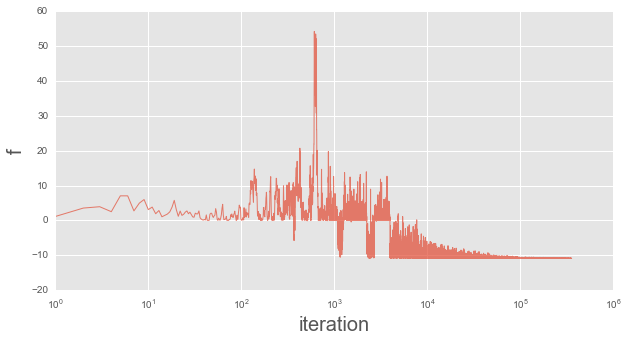

In [18]:
# adjust plot to fit the notebook
plt.figure(figsize=(10,5))

plt.plot(range(len(out)),[e[2] for e in out], alpha=0.7, lw=1);
plt.xscale('log', fontsize=20)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('f', fontsize=20)

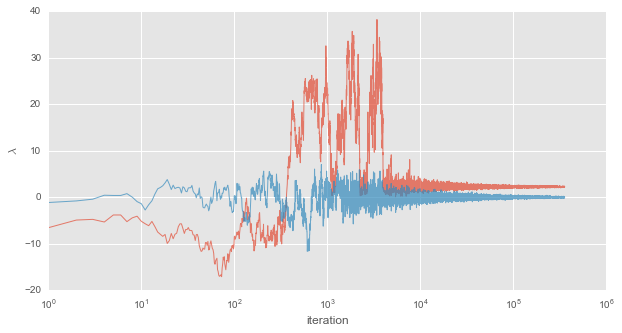

In [19]:
plt.figure(figsize=(10,5))
plt.plot([e[1] for e in out], alpha=0.7, lw=1);
plt.xscale('log')
plt.xlabel('iteration')
plt.ylabel('$\lambda$')

# Use a minimum length of 500 and max temp of 25

In [20]:
lambdas_init = [-5, 0]
inits=dict(solution=lambdas_init, length=500, T=25)
bmeta, bs, be, out = sa(f, inits, 30, tf, itf, pfxs)

Epoch 0
Temperature 25 Length 500
Epoch 1
Temperature 20.0 Length 600
Epoch 2
Temperature 16.0 Length 720
Epoch 3
Temperature 12.8 Length 864
Epoch 4
Temperature 10.240000000000002 Length 1037
Epoch 5
Temperature 8.192000000000002 Length 1245
Epoch 6
Temperature 6.553600000000002 Length 1494
Epoch 7
Temperature 5.242880000000002 Length 1793
Epoch 8
Temperature 4.194304000000002 Length 2152
Epoch 9
Temperature 3.3554432000000016 Length 2583
Epoch 10
Temperature 2.6843545600000014 Length 3100
Epoch 11
Temperature 2.147483648000001 Length 3720
Epoch 12
Temperature 1.717986918400001 Length 4464
Epoch 13
Temperature 1.3743895347200008 Length 5357
Epoch 14
Temperature 1.0995116277760006 Length 6429
Epoch 15
Temperature 0.8796093022208006 Length 7715
Epoch 16
Temperature 0.7036874417766406 Length 9258
Epoch 17
Temperature 0.5629499534213125 Length 11110
Epoch 18
Temperature 0.45035996273705003 Length 13332
Epoch 19
Temperature 0.36028797018964004 Length 15999
Epoch 20
Temperature 0.2882303761

In [21]:
# print the best solution (bs) and best energy (be)
bs, be

(array([ 2.22008341, -0.06476858]), -10.843613781176373)

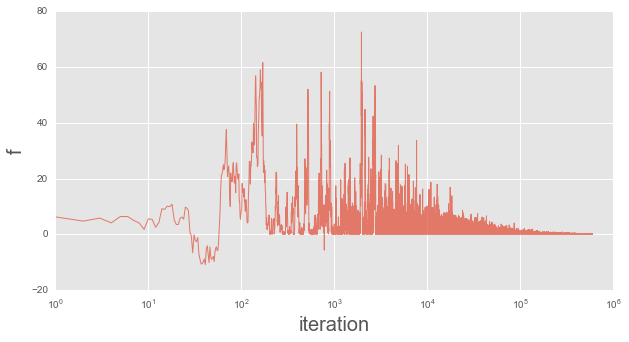

In [22]:
# adjust plot to fit the notebook
plt.figure(figsize=(10,5))

plt.plot(range(len(out)),[e[2] for e in out], alpha=0.7, lw=1);
plt.xscale('log', fontsize=20)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('f', fontsize=20)

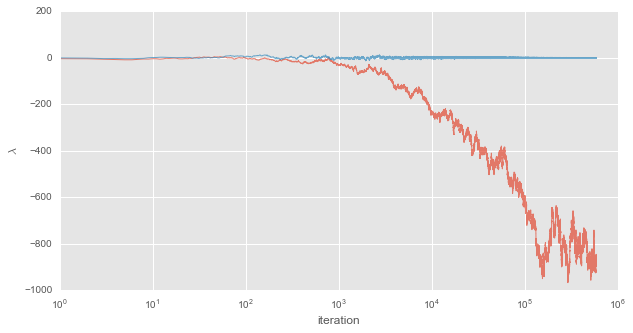

In [23]:
plt.figure(figsize=(10,5))
plt.plot([e[1] for e in out], alpha=0.7, lw=1);
plt.xscale('log')
plt.xlabel('iteration')
plt.ylabel('$\lambda$')

# Use a minimum length of 1500 and max temp of 10

In [24]:
lambdas_init = [-5, 0]
inits=dict(solution=lambdas_init, length=1500, T=10)
bmeta, bs, be, out = sa(f, inits, 30, tf, itf, pfxs)

Epoch 0
Temperature 10 Length 1500
Epoch 1
Temperature 8.0 Length 1800
Epoch 2
Temperature 6.4 Length 2160
Epoch 3
Temperature 5.120000000000001 Length 2592
Epoch 4
Temperature 4.096000000000001 Length 3111
Epoch 5
Temperature 3.276800000000001 Length 3734
Epoch 6
Temperature 2.621440000000001 Length 4481
Epoch 7
Temperature 2.097152000000001 Length 5378
Epoch 8
Temperature 1.6777216000000008 Length 6454
Epoch 9
Temperature 1.3421772800000007 Length 7745
Epoch 10
Temperature 1.0737418240000005 Length 9294
Epoch 11
Temperature 0.8589934592000005 Length 11153
Epoch 12
Temperature 0.6871947673600004 Length 13384
Epoch 13
Temperature 0.5497558138880003 Length 16061
Epoch 14
Temperature 0.4398046511104003 Length 19274
Epoch 15
Temperature 0.3518437208883203 Length 23129
Epoch 16
Temperature 0.28147497671065624 Length 27755
Epoch 17
Temperature 0.22517998136852502 Length 33306
Epoch 18
Temperature 0.18014398509482002 Length 39968
Epoch 19
Temperature 0.14411518807585602 Length 47962
Epoch 20

In [25]:
# print the best solution (bs) and best energy (be)
bs, be

(array([  2.23554403e+00,   6.60760952e-04]), -10.850394482705269)

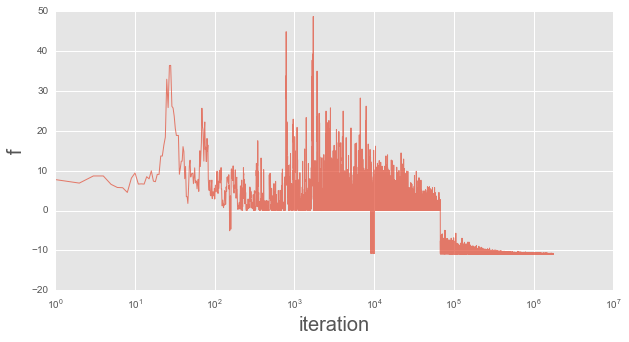

In [26]:
# adjust plot to fit the notebook
plt.figure(figsize=(10,5))

plt.plot(range(len(out)),[e[2] for e in out], alpha=0.7, lw=1);
plt.xscale('log', fontsize=20)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('f', fontsize=20)

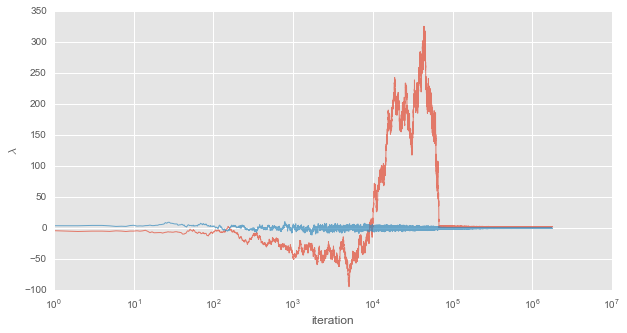

In [27]:
plt.figure(figsize=(10,5))
plt.plot([e[1] for e in out], alpha=0.7, lw=1);
plt.xscale('log')
plt.xlabel('iteration')
plt.ylabel('$\lambda$')

In order to find how slowly the annealing process needs to be in order to reach the global minimum, I adjusted the maximum temperature and minimum length settings for simulated annealing.  Each set located the "best energy" near the calculated global minimum.  As the minimum length increased, the computational time also increased. 